In [1]:
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

os.chdir(sys.path[0])

import utils

In [2]:
%matplotlib inline

In [3]:
main_path = Path.cwd() / ".."

### Ejercicio 1.
Para las imagenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grises y visualizarlas

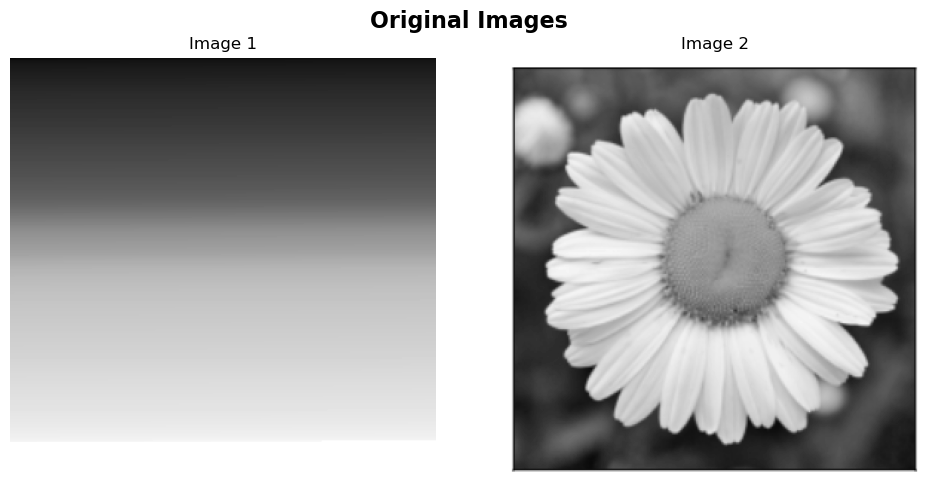

In [4]:
folder_path = main_path / "data/histogram"

list_imgs = utils.load_imgs(folder_path, is_gray=True)

utils.plot_imgs(list_imgs, "Original Images", rows=1, cols=2, is_gray=True)

### Ejercicio 2.
Elija el número de bins que crea conveniente y grafique su historgrama, compare los histogramas entre si. Explicar lo que se observa. Si tuviera que entrenar un modelo de clasificación/detección de imágenes, considera que puede ser de utilidad utilizar los histogramas como features?

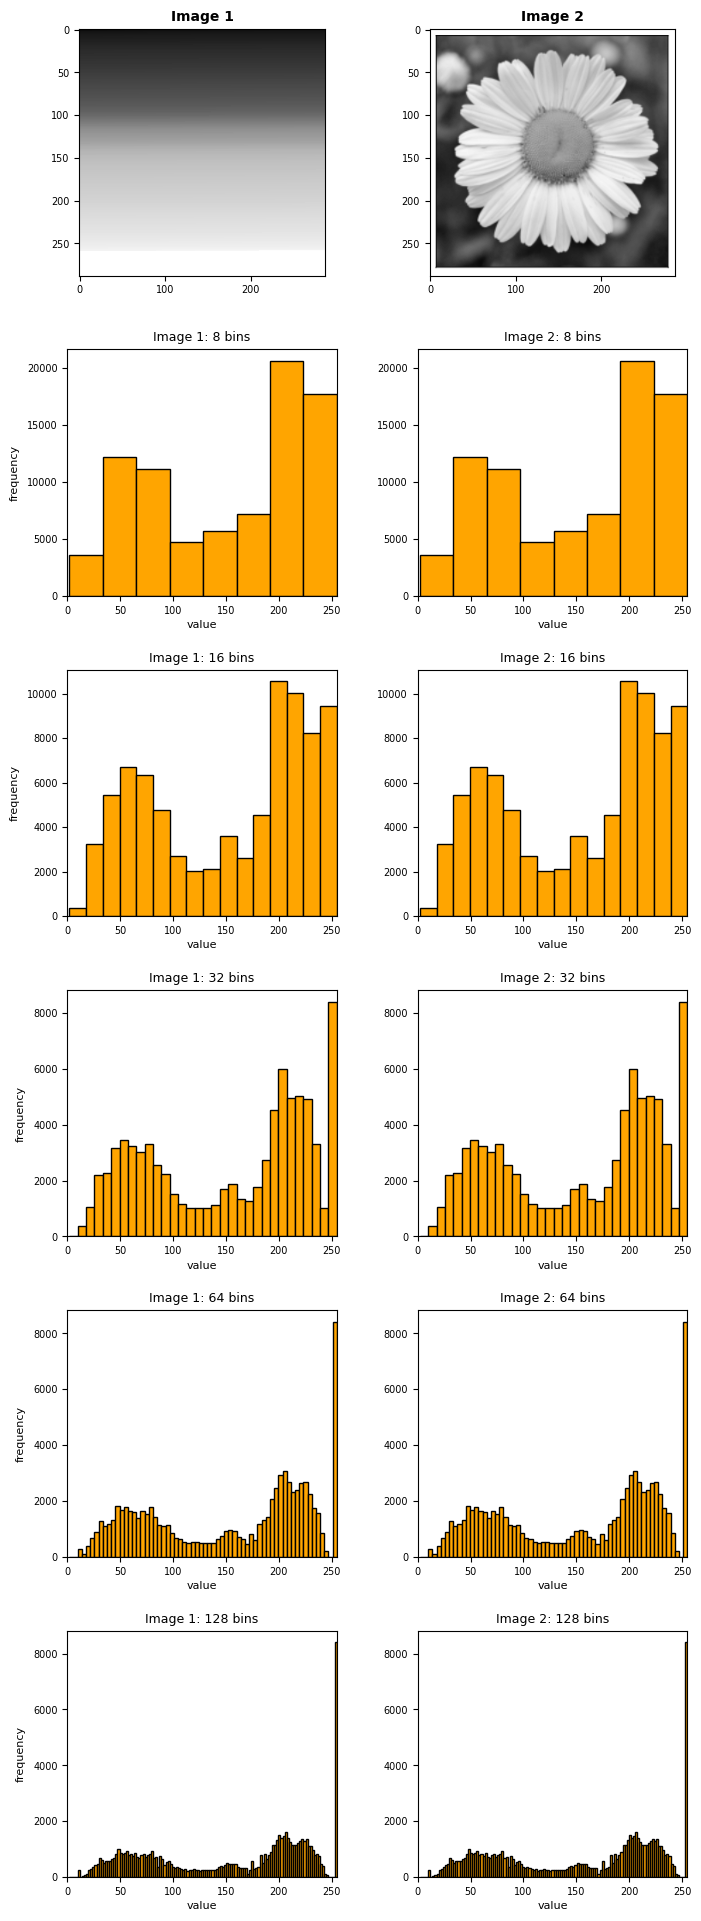

In [5]:
list_bins = [8, 16, 32, 64, 128]
plt.figure(figsize=(8, 4 * (1 + len(list_bins))))

plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.3)

for i, img in enumerate(list_imgs):
    i_n = i + 1
    plt.subplot(6, 2, i_n)
    plt.imshow(img, cmap="gray")

    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)

    plt.title(f"Image {i_n}", fontsize=10, fontweight="bold")

    for j, num_bins in enumerate(list_bins):
        j_n = j + 1
        plt.subplot(6, 2, i_n + j_n * 2)

        plt.hist(
            img.flatten(), bins=num_bins, color="orange", edgecolor="black"
        )

        plt.xlim(0, 255)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)

        plt.xlabel("value", labelpad=3, fontsize=8)
        if i_n == 1:
            plt.ylabel("frequency", rotation=90, labelpad=5, fontsize=8)

        plt.title(f"Image {i_n}: {num_bins} bins", fontsize=9)


plt.show()

Podemos observar que dos imágenes sumamente diferentes entre si poseen el mismo histograma de valores de píxel. Esto indica que el histograma no resultará útil como feature para entrenar un modelo de clasificación/detección de objetos.

### Ejercicio 3.
Para la imagen segmentacion.png analice el histograma de los canales rgb. Segmente algunos de los elementos presentes en la imagen (agua, cielo, tierra) y muestre, aplicando máscaras, las regiones en imágenes separadas.

In [6]:
def get_channel_color(i, is_hsv=False):
    if is_hsv:
        channel = "Hue" if i==0 else "Saturation" if i==1 else "Value"
        color = None
    else:
        channel = "Blue" if i==0 else "Green" if i==1 else "Red"
        color = "b" if i==0 else "g" if i==1 else "r"

    return (channel, color)

In [7]:
folder_path = main_path / "data/segmentation"
filename = "segmentacion.png"
file_path = os.path.join(folder_path, filename)

img_seg = img = cv2.imread(file_path)

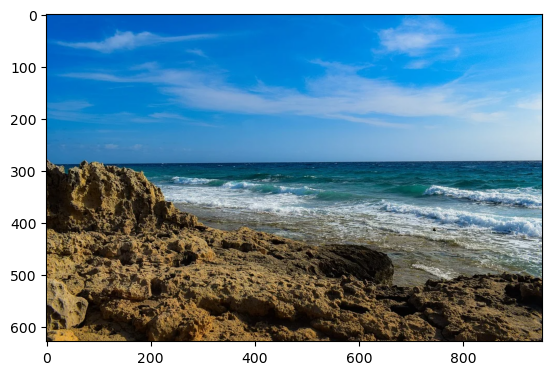

In [8]:
plt.imshow(cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB))

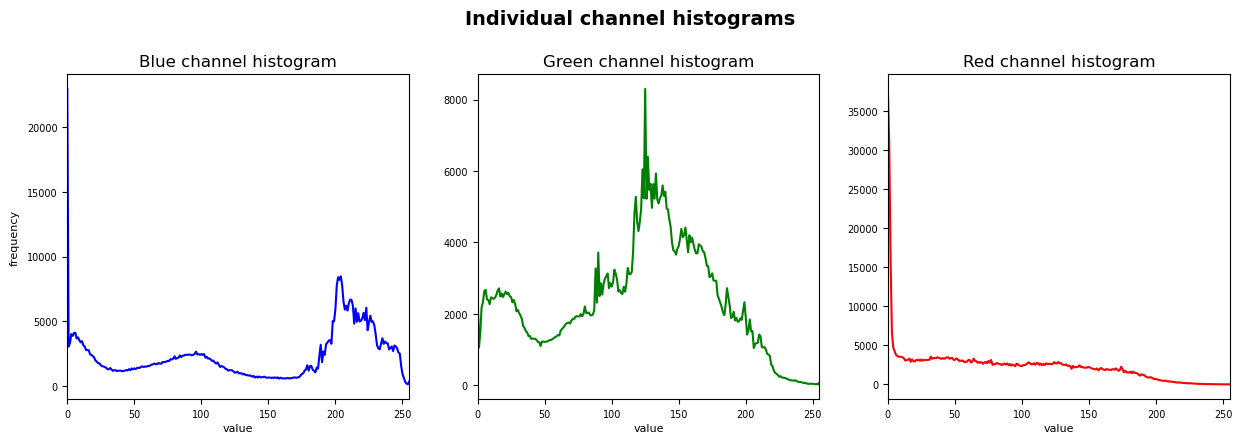

In [9]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(top=.85, bottom=0.2)

plt.suptitle("Individual channel histograms", fontsize=14, fontweight="bold")

for i in range(img_seg.shape[-1]):
    plt.subplot(1, 3, i + 1)

    channel, color = get_channel_color(i)

    hist = cv2.calcHist(
        images=[img_seg], channels=[i], mask=None, histSize=[256], ranges=[0, 256]
    )

    # plot the above computed histogram
    plt.plot(hist, color=color)
    plt.title(f"{channel} channel histogram")

    plt.xlim(0, 255)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)

    plt.xlabel("value", labelpad=3, fontsize=8)
    if i == 0:
        plt.ylabel("frequency", rotation=90, labelpad=5, fontsize=8)

plt.show()

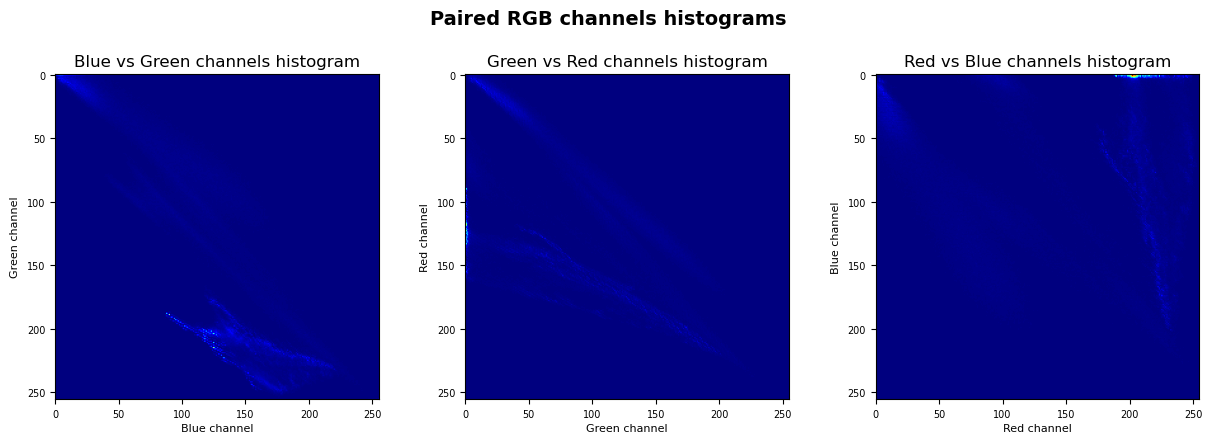

In [10]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(top=.85, bottom=0.2)

plt.suptitle("Paired RGB channels histograms", fontsize=14, fontweight="bold")

for i in range(img_seg.shape[-1]):
    j = i + 1 if i < 2 else 0

    plt.subplot(1, 3, i + 1)

    channel_x, _ = get_channel_color(i)
    channel_y, _ = get_channel_color(j)

    hist = cv2.calcHist(
        images=[img_seg], channels=[i, j], mask=None, histSize=[256, 256], ranges=[0, 256, 0, 256]
    )

    # plot the above computed histogram
    plt.imshow(hist, cmap='jet')
    plt.title(f"{channel_x} vs {channel_y} channels histogram")

    plt.xlim(0, 255)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)

    plt.xlabel(f"{channel_x} channel", labelpad=3, fontsize=8)
    plt.ylabel(f"{channel_y} channel", rotation=90, labelpad=5, fontsize=8)

plt.show()

Se observa en los histogramas 2D que la diagonal se encuentra marcada (píxeles con valores similares en ambos canales) especialmente para valores de píxel bajos. Además se encuentra en cada uno de los histogramas 2D graficados ciertas "manchas" por fuera de la diagonal, esto es más notorio en el cruce entre el canal azul y los demás.

##### HSV space

Como vimos en la teórica, el espacio de color HSV presenta un mayor potencial para segmentar los objetos presentes en la imagen. Por eso vamos a proyectar la imagen al mencionado espacio de color para realizar el ejercicio.

In [11]:
img_seg_hsv = cv2.cvtColor(img_seg, cv2.COLOR_BGR2HSV)

img_seg_hsv.max(axis=(0, 1))

array([179, 255, 255], dtype=uint8)

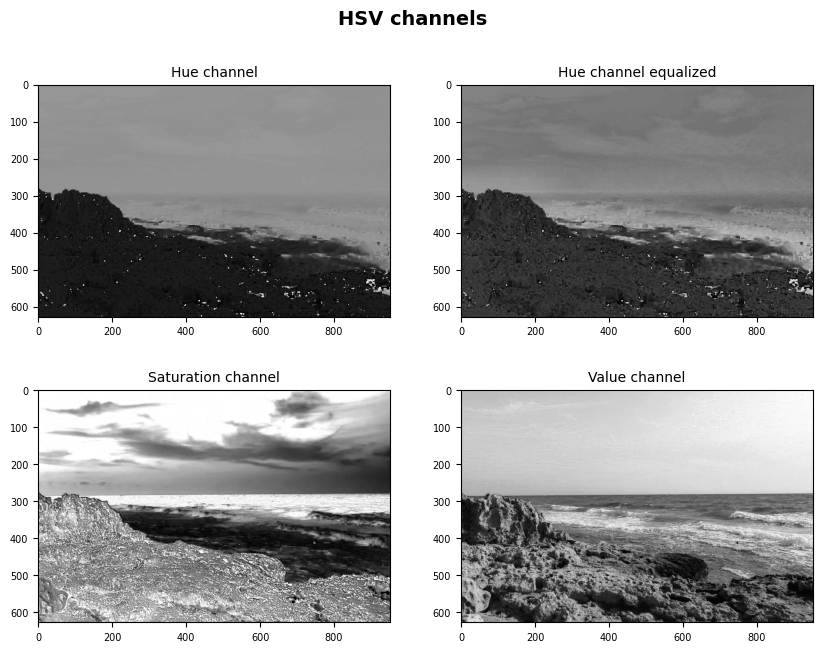

In [12]:
plt.figure(figsize=(10, 8))
plt.subplots_adjust(top=0.9, bottom=0.2)

plt.suptitle("HSV channels", fontsize=14, fontweight="bold")

for i in range(img_seg_hsv.shape[-1]):
    img = img_seg_hsv[:, :, i].copy()

    channel_x, _ = get_channel_color(i, is_hsv=True)

    if i == 0:
        for j in range(2):
            plt.subplot(2, 2, i + 1 + j)

            if j == 1:
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                img = clahe.apply(img)

            # plot the above computed histogram
            plt.imshow(img, cmap="gray")

            title = f"{channel_x} channel" if j == 0 else f"{channel_x} channel equalized"
            plt.title(title, fontsize=10)

            plt.xticks(fontsize=7)
            plt.yticks(fontsize=7)
    else:
        plt.subplot(2, 2, i + 2)

        # plot the above computed histogram
        plt.imshow(img, cmap="gray")

        title = f"{channel_x} channel"
        plt.title(title, fontsize=10)

        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)

plt.show()

Se observa que el canal de saturación es útil para separar la tierra del agua y que el canal de valor es útil para separar el cielo del agua.

Se observa además que equalizar el canal de Hue no contribuye sustancialmente a segmentar los elementos, por lo que vamos a trabajar con el canal Hue original.

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

def plot_color_dist(rgb_img, hsv_channels, hue_equalized=False):
    c1, c2, c3 = hsv_channels
    
    fig = plt.figure(figsize=(15, 5))
    for i in range(3):
        axis = fig.add_subplot(1, 3, i+1, projection="3d")

        axis.view_init(elev=75-(i*25), azim=270-i*45)

        pixel_colors = rgb_img.reshape((np.shape(rgb_img)[0]*np.shape(rgb_img)[1], 3))
        norm = colors.Normalize(vmin=-1.,vmax=1.)
        norm.autoscale(pixel_colors)
        pixel_colors = norm(pixel_colors).tolist()

        axis.scatter(c1.flatten(), c2.flatten(), c3.flatten(), facecolors=pixel_colors, marker=".")
        hue_title = "Hue channel eq." if hue_equalized else "Hue channel"
        axis.set_xlabel(hue_title)
        axis.set_ylabel("Saturation channel")
        axis.set_zlabel("Value channel")

    plt.show()

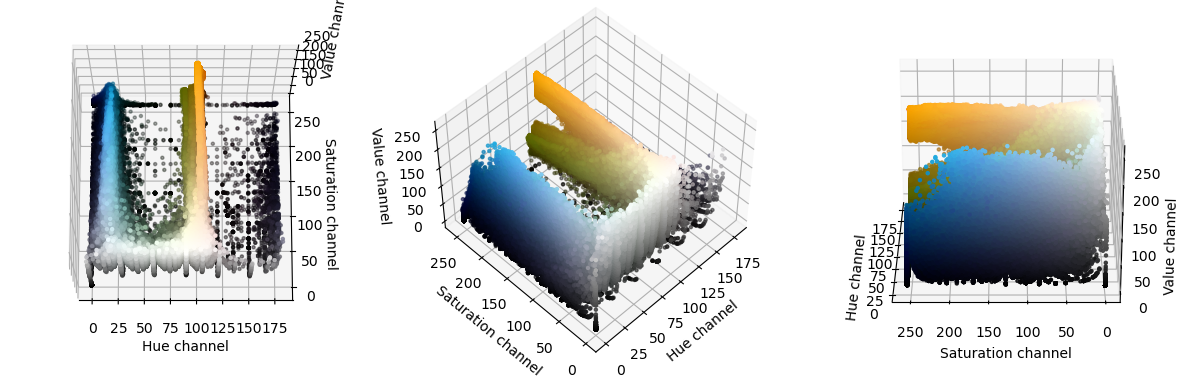

In [14]:
c1, c2, c3 = cv2.split(img_seg_hsv)

plot_color_dist(img_seg, (c1, c2, c3))

El canal de Hue se ve bastante útil para segmentar el cielo y la tierra. Podemos observar que la distribución de ese canal es bimodal, por lo que si queremos segmentar 3 objetos diferentes sólo con ese canal va a resultar complejo. Utilizar los restantes canales puede resultar útil para separar el agua, ya que sus valores de Hue parecen mezclarse con los del cielo y la tierra.

##### Segmentación de objetos

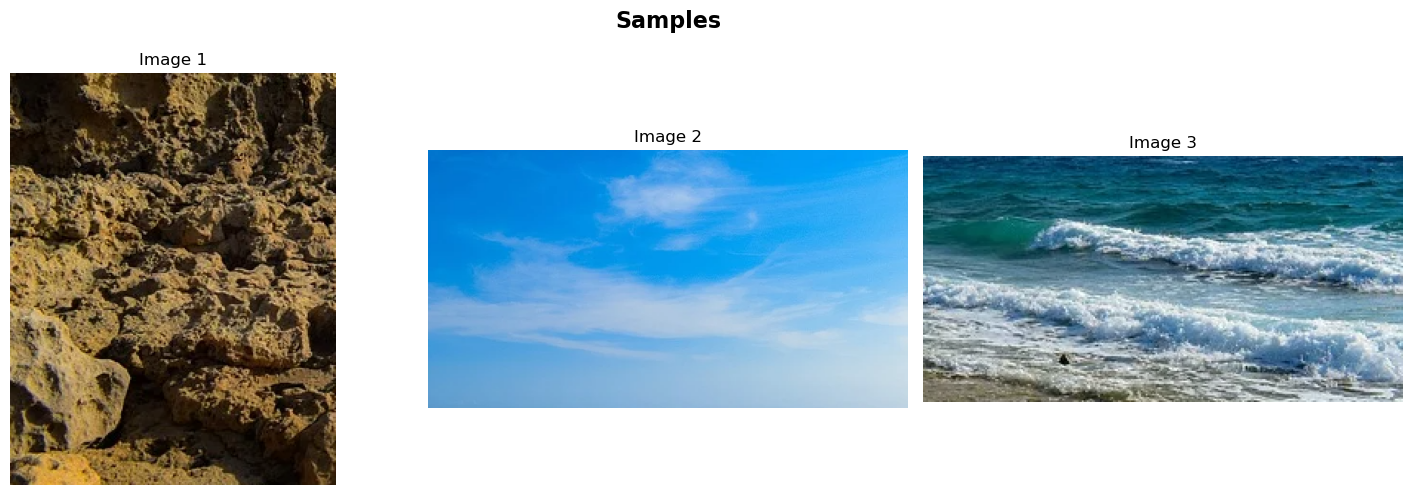

In [15]:
# Tierra
earth_sample = img_seg[350:800, 0:220]
sky_sample = img_seg[0:270, 450:]
water_sample = img_seg[290:440, 660:]

utils.plot_imgs([earth_sample, sky_sample, water_sample], title="Samples", rows=1, cols=3)

El cielo y la tierra se ven mayormente homogéneos. No así el agua, que posee colores cercanos al cielo y colores cercanos a la tierra. Vamos a probar segmentar la tierra y el cielo; y considerar al agua como el área que no es cielo ni tierra.

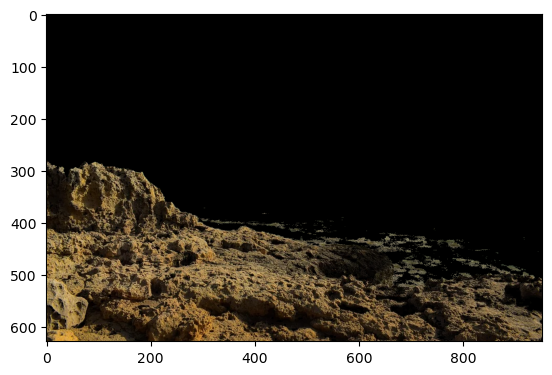

In [16]:
sample_hsv = img_seg_hsv[350:800, 0:220]

sample_mean = sample_hsv.mean(axis=(0, 1))
sample_std = sample_hsv.std(axis=(0, 1))

color_l = (17.38-(3*11.36), 50, 0)
color_u = (17.38+(3*11.36),255,255)

earth_mask = cv2.inRange(img_seg_hsv, color_l,  color_u)
img_segmentada = cv2.bitwise_and(img_seg, img_seg, mask=earth_mask)

plt.figure(6)
plt.imshow(img_segmentada[:, :, ::-1])
plt.show()

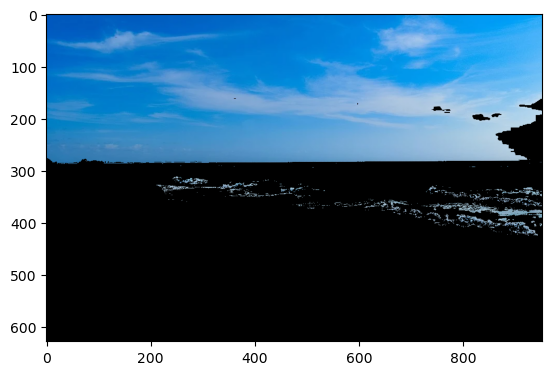

In [17]:
sample_hsv = img_seg_hsv[0:270, 450:]

sample_mean = sample_hsv.mean(axis=(0, 1))
sample_std = sample_hsv.std(axis=(0, 1))

color_l = (sample_mean[0]-(3*sample_std[0]), 50, 170)
color_u = (sample_mean[0]+(3*sample_std[0]),255, 255)

sky_mask = cv2.inRange(img_seg_hsv, color_l,  color_u)
img_segmentada = cv2.bitwise_and(img_seg, img_seg, mask=sky_mask)

plt.figure(6)
plt.imshow(img_segmentada[:, :, ::-1])
plt.show()

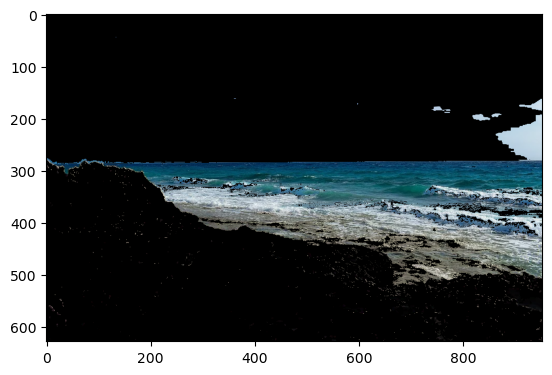

In [18]:
img_segmentada = cv2.bitwise_and(img_seg, img_seg, mask=(~earth_mask & ~sky_mask))

plt.figure(6)
plt.imshow(img_segmentada[:, :, ::-1])
plt.show()